# **7.B Advanced Tree Models – Random Forests**

Maintainer: Zhaohu(Jonathan) Fan. Contact him at (psujohnny@gmail.com)


Note: This lab note is still WIP, let us know if you encounter bugs or issues.

1. [Random Forests](#1-random-forests)  
   1.1 [Random Forest for Regression](#11-random-forest-for-regression)  
   1.2 [Random Forest for Classification](#12-random-forest-for-classification)  




#### *Colab Notebook [Open in Colab](https://colab.research.google.com/drive/1hA4wjDzjrfq6lNxRHh_JumqFDiZ9Rkkd?usp=sharing)*

#### *Useful information about [Advanced Tree Models – Random Forests in R](https://yanyudm.github.io/Data-Mining-R/lecture/7.B_RandomForests.html)*



## Random Forests

**Random forests** are an extension of **bagging**, but they often deliver better predictive performance. The key idea is to **randomly select** m  out of  p predictors as candidate variables at **each split** in each tree.

A common default is:
 $$m=\sqrt{p} ~~\text{for classification}$$
 $$m\approx p/3~~~\text{for regression}$$
This randomness helps **decorrelate** the individual trees, which typically **reduces variance** when we aggregate predictions across trees.

For more details, see <a href="https://en.wikipedia.org/wiki/Random_forest">Wikipedia</a> and the <a href="https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm">tutorial</a> on the author’s website.


### 1.1 Random Forest for Regression
We start with Boston Housing data.

In [4]:
# ============================================================
# Random Forest for Regression (Boston Housing)
# - Continue using your Boston data loader (CMU StatLib) and 90/10 split
# - Replicates the R workflow: fit RF, variable importance, OOB error curve,
#   test MSE, and mtry (max_features) sensitivity for OOB/test error.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 123

# ------------------------------------------------------------
# 0. Load Boston Housing data (CMU StatLib format) — your method
# ------------------------------------------------------------
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep=r"\s+", skiprows=22, header=None)

data = np.hstack([
    raw_df.values[::2, :],
    raw_df.values[1::2, :2]
])
target = raw_df.values[1::2, 2]

feature_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE",
    "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"
]

boston = pd.DataFrame(data, columns=feature_names)
boston["MEDV"] = target

# ------------------------------------------------------------
# 1. Train/Test split (90/10)
# ------------------------------------------------------------
X = boston.drop(columns=["MEDV"])
y = boston["MEDV"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=RANDOM_STATE
)

p = X_train.shape[1]
print("p =", p, " | train:", X_train.shape, " test:", X_test.shape)


p = 13  | train: (455, 13)  test: (51, 13)


In [5]:
# ============================================================
# 1. Fit Random Forest Regressor (default analog of R: ntree=500, mtry ~ p/3)
# In sklearn:
# - n_estimators = ntree
# - max_features = mtry (for regression, default is 1.0 in sklearn, so we set it)
# - oob_score=True enables OOB prediction-based scoring (R^2 in sklearn)
# ============================================================

mtry_default = max(1, p // 3)  # p/3 ≈ 4 for Boston

rf = RandomForestRegressor(
    n_estimators=500,
    max_features=mtry_default,
    bootstrap=True,
    oob_score=True,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Test MSE
pred_test = rf.predict(X_test)
test_mse = mean_squared_error(y_test, pred_test)

# OOB MSE (sklearn's oob_score_ is R^2; compute MSE from oob_prediction_)
oob_pred = rf.oob_prediction_
oob_mse = mean_squared_error(y_train, oob_pred)

print(f"\nRandom Forest (ntree=500, mtry={mtry_default})")
print(f"  OOB R^2 (sklearn): {rf.oob_score_:.5f}")
print(f"  OOB MSE:          {oob_mse:.5f}")
print(f"  Test MSE:         {test_mse:.5f}")


Random Forest (ntree=500, mtry=4)
  OOB R^2 (sklearn): 0.88466
  OOB MSE:          9.25702
  Test MSE:         21.33393


In [6]:
# ============================================================
# 2. Variable importance (analog to randomForest importance=TRUE)
# - sklearn provides impurity-based importance (IncNodePurity analogue)
# ============================================================

imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop feature importances:")
print(imp)



Top feature importances:
RM         0.318668
LSTAT      0.262070
INDUS      0.065923
CRIM       0.064703
PTRATIO    0.064079
NOX        0.063706
DIS        0.058613
TAX        0.039880
AGE        0.025553
B          0.017130
ZN         0.009183
RAD        0.008679
CHAS       0.001814
dtype: float64


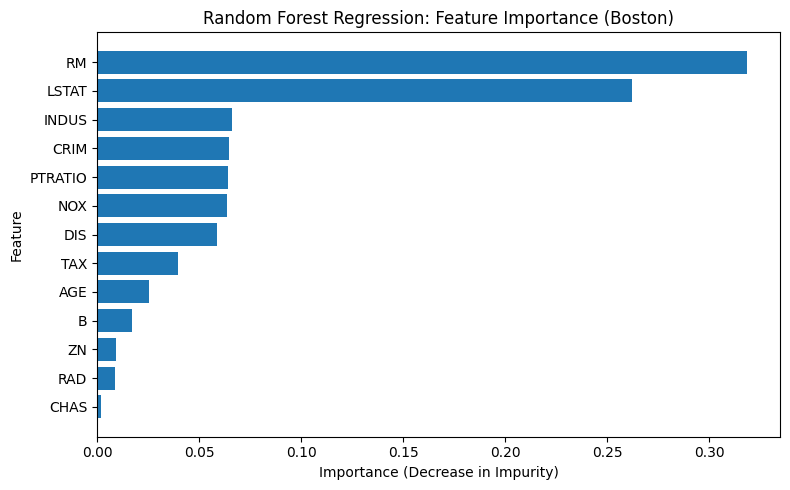

In [7]:
plt.figure(figsize=(8, 5))
plt.barh(imp.index[::-1], imp.values[::-1])
plt.xlabel("Importance (Decrease in Impurity)")
plt.ylabel("Feature")
plt.title("Random Forest Regression: Feature Importance (Boston)")
plt.tight_layout()
plt.show()


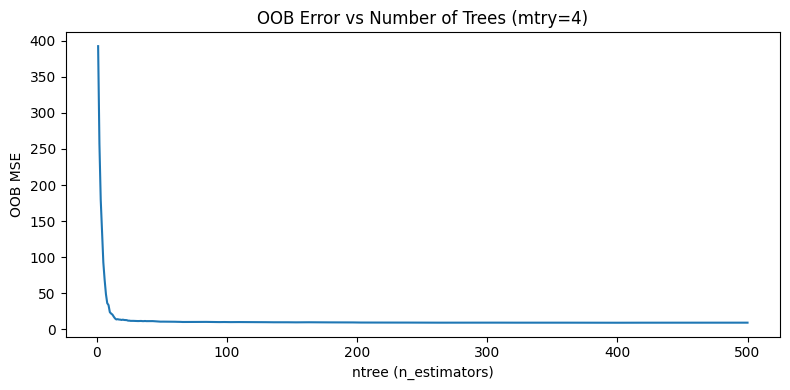

In [12]:
# ============================================================
# 3. OOB error curve vs ntree (like plot(boston_rf$mse))
# - In sklearn, we approximate the OOB MSE curve by refitting forests with
#   different n_estimators and recording OOB MSE each time.
# ============================================================

ntree_grid = list(range(1, 501))  # 1..500
oob_mse_curve = []

for n in ntree_grid:
    rf_n = RandomForestRegressor(
        n_estimators=n,
        max_features=mtry_default,
        bootstrap=True,
        oob_score=True,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    rf_n.fit(X_train, y_train)
    oob_mse_curve.append(mean_squared_error(y_train, rf_n.oob_prediction_))

plt.figure(figsize=(8, 4))
plt.plot(ntree_grid, oob_mse_curve)
plt.xlabel("ntree (n_estimators)")
plt.ylabel("OOB MSE")
plt.title(f"OOB Error vs Number of Trees (mtry={mtry_default})")
plt.tight_layout()
plt.show()


In [28]:
# ============================================================
# 4. Test MSE (prediction on the testing sample) — already computed above
# ============================================================
print(f"OOB MSE:  {oob_mse:.5f}")
print(f"Test MSE: {test_mse:.5f}")


OOB MSE:  9.19606
Test MSE: 21.45336


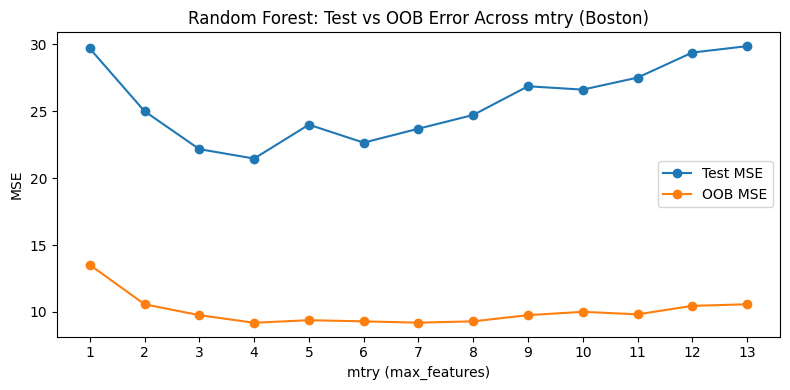

In [27]:
# ============================================================
# 5. Sensitivity to mtry (max_features): compare OOB MSE and Test MSE
# R code loops i=1..13 and uses OOB mse[500] and test error
# ============================================================

mtry_values = list(range(1, p + 1))
oob_err = []
test_err = []

for m in mtry_values:
    fit_m = RandomForestRegressor(
        n_estimators=500,
        max_features=m,
        bootstrap=True,
        oob_score=True,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    fit_m.fit(X_train, y_train)

    oob_m = mean_squared_error(y_train, fit_m.oob_prediction_)
    test_m = mean_squared_error(y_test, fit_m.predict(X_test))

    oob_err.append(oob_m)
    test_err.append(test_m)

plt.figure(figsize=(8, 4))
plt.plot(mtry_values, test_err, marker="o", label="Test MSE")
plt.plot(mtry_values, oob_err, marker="o", label="OOB MSE")
plt.xlabel("mtry (max_features)")
plt.ylabel("MSE")
plt.title("Random Forest: Test vs OOB Error Across mtry (Boston)")
plt.xticks(mtry_values)
plt.legend()
plt.tight_layout()
plt.show()


**Implementation notes (R vs. scikit-learn):**

- In R’s `randomForest`, **`mtry`** corresponds to scikit-learn’s **`max_features`** in `RandomForestRegressor` / `RandomForestClassifier`.

- R reports the **out-of-bag (OOB) MSE** directly. In scikit-learn, `oob_score_` reports the **OOB R²** (for regression).  
  To match R’s output, we compute **OOB MSE** using `oob_prediction_`:

  $$  \text{OOB MSE} = \frac{1}{n}\sum_{i=1}^{n}\left(y_i - \hat{y}^{\text{OOB}}_i\right)^2
 $$


### 1.2 Random Forest for Classification

We apply the random forest model to the **credit card default** dataset.


In [29]:
# ============================================================
# Random Forest for Classification — Credit Card Default (Google Colab)
#   - 90/10 train/test split
#   - One-hot encode categorical predictors
#   - Fit RandomForestClassifier (500 trees)
#   - OOB error rate + confusion matrix (OOB)
#   - Error vs ntree (OOB error curve)
#   - ROC curve + AUC using predicted probabilities
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score
)

RANDOM_STATE = 123


In [30]:
# ============================================================
# 1) Load credit card data
# ============================================================
credit_url = "https://yanyudm.github.io/Data-Mining-R/lecture/data/credit_default.csv"
credit_data = pd.read_csv(credit_url)

# Convert categorical variables (similar to as.factor in R)
for col in ["SEX", "EDUCATION", "MARRIAGE"]:
    credit_data[col] = credit_data[col].astype("category")

credit_data.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,290000,2,2,2,26,0,0,0,0,-1,...,100000,3015,23473,3000,80000,3000,3015,23473,1148,0
1,20000,1,2,2,51,-1,-1,-2,-1,-1,...,780,0,0,0,0,2280,0,0,0,0
2,280000,1,1,2,29,-2,-2,-2,-2,-2,...,2510,591,14994,5123,8467,2510,591,14994,5000,0
3,280000,2,1,2,47,0,0,0,0,0,...,184270,130954,92215,11268,8196,6281,4403,3532,3510,0
4,20000,1,2,2,24,0,0,0,0,0,...,19396,11643,11578,1400,1380,1181,1000,500,500,0


In [31]:
# ============================================================
# 2) Train/Test split (90/10)
# ============================================================
target_col = "default.payment.next.month"

X = credit_data.drop(columns=[target_col])
y = credit_data[target_col].astype(int)  # ensure 0/1 integers

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=RANDOM_STATE, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train default rate:", y_train.mean().round(4), "Test default rate:", y_test.mean().round(4))


Train: (10800, 23) Test: (1200, 23)
Train default rate: 0.2194 Test default rate: 0.2192


In [32]:
# ============================================================
# 3) One-hot encode categorical variables
#    (RandomForest in sklearn needs numeric inputs)
# ============================================================
X_train_enc = pd.get_dummies(X_train, drop_first=False)
X_test_enc  = pd.get_dummies(X_test, drop_first=False)

# Align columns (in case a category appears in train but not test or vice versa)
X_train_enc, X_test_enc = X_train_enc.align(X_test_enc, join="left", axis=1, fill_value=0)

X_train_enc.shape, X_test_enc.shape


((10800, 29), (1200, 29))

In [33]:
# ============================================================
# 4) Fit Random Forest Classifier (ntree=500) with OOB
#    - In R, default mtry for classification is sqrt(p)
#    - In sklearn, max_features="sqrt" matches that behavior
# ============================================================
credit_rf = RandomForestClassifier(
    n_estimators=500,
    max_features="sqrt",
    bootstrap=True,
    oob_score=True,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

credit_rf.fit(X_train_enc, y_train)

# OOB predicted class + OOB error rate
oob_prob = credit_rf.oob_decision_function_[:, 1]
oob_pred = (oob_prob >= 0.5).astype(int)

cm_oob = confusion_matrix(y_train, oob_pred)
oob_error_rate = 1.0 - credit_rf.oob_score_  # sklearn oob_score_ = accuracy

print(f"Number of trees: {credit_rf.n_estimators}")
print(f"max_features:   {credit_rf.max_features}")
print(f"OOB accuracy:   {credit_rf.oob_score_:.4f}")
print(f"OOB error rate: {oob_error_rate:.4f}\n")

print("OOB Confusion Matrix (train, using OOB predictions):")
print(cm_oob)


Number of trees: 500
max_features:   sqrt
OOB accuracy:   0.8152
OOB error rate: 0.1848

OOB Confusion Matrix (train, using OOB predictions):
[[7914  517]
 [1480  889]]


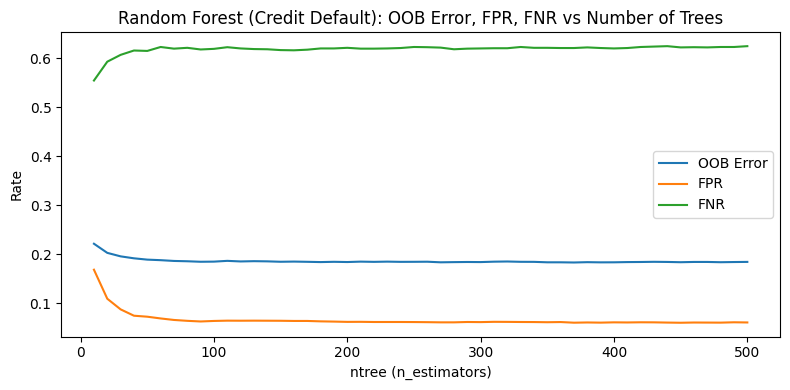

In [34]:
# ============================================================
# 5) Error vs ntree (approximate plot(credit_rf) from R)
#    We'll use warm_start=True to build trees incrementally and
#    record:
#      - OOB error rate
#      - OOB FPR and OOB FNR at threshold 0.5
# ============================================================

from sklearn.metrics import confusion_matrix

ntree_grid = list(range(10, 501, 10))

oob_err_curve = []
fpr_curve = []
fnr_curve = []

rf_ws = RandomForestClassifier(
    n_estimators=10,
    max_features="sqrt",
    bootstrap=True,
    oob_score=True,
    warm_start=True,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

for n in ntree_grid:
    rf_ws.set_params(n_estimators=n)
    rf_ws.fit(X_train_enc, y_train)

    oob_prob_n = rf_ws.oob_decision_function_[:, 1]
    oob_pred_n = (oob_prob_n >= 0.5).astype(int)

    cm = confusion_matrix(y_train, oob_pred_n)
    tn, fp, fn, tp = cm.ravel()

    oob_acc = rf_ws.oob_score_
    oob_err = 1.0 - oob_acc

    fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
    fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan

    oob_err_curve.append(oob_err)
    fpr_curve.append(fpr)
    fnr_curve.append(fnr)

plt.figure(figsize=(8, 4))
plt.plot(ntree_grid, oob_err_curve, label="OOB Error")
plt.plot(ntree_grid, fpr_curve, label="FPR")
plt.plot(ntree_grid, fnr_curve, label="FNR")
plt.xlabel("ntree (n_estimators)")
plt.ylabel("Rate")
plt.title("Random Forest (Credit Default): OOB Error, FPR, FNR vs Number of Trees")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# 6) ROC curve + AUC (based on probability predictions)
#    - R code computes ROC on training set probabilities
#    - We'll compute ROC/AUC for both training (OOB) and test
# ============================================================

# (A) Training ROC using OOB probabilities (closest analogue to R's internal estimate)
fpr_oob, tpr_oob, _ = roc_curve(y_train, oob_prob)
auc_oob = roc_auc_score(y_train, oob_prob)

# (B) Test ROC using predicted probabilities on held-out test set
test_prob = credit_rf.predict_proba(X_test_enc)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, test_prob)
auc_test = roc_auc_score(y_test, test_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr_oob, tpr_oob, label=f"Train ROC (OOB) AUC = {auc_oob:.4f}")
plt.plot(fpr_test, tpr_test, label=f"Test ROC AUC = {auc_test:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve: Random Forest (Credit Default)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Train (OOB) AUC: {auc_oob:.4f}")
print(f"Test AUC:        {auc_test:.4f}")


In [ ]:
%%shell
jupyter nbconvert --to html ///content/7B_Advanced_Tree_Models_–_Random_Forests.ipynb

[NbConvertApp] Converting notebook ///content/7B_Advanced_Tree_Models_–_Random_Forests.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 319439 bytes to /content/7B_Advanced_Tree_Models_–_Random_Forests.html
